# Download dan Import Library yang dibutuhkan

In [ ]:
pip install jcopdl

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=a4de1fc528bccb5c0cdc11c395a2686555e4d268ec58e2379ddfe40952d40cbe
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


In [ ]:
pip install luwiji

     |████████████████████████████████| 40.3MB 101kB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
  Created wheel for luwiji: filename=luwiji-1.1.8-py2.py3-none-any.whl size=40371111 sha256=c5b8ffdec6a2fd4f43f7088f2a9663d9666638623bca9a91d5208e8550df84c1
  Stored in directory: /root/.cache/pip/wheels/a8/b7/68/084583dfcdac4fbe9ef870c03065173091c7b7c481b946a8ee
  Created wheel for jcopml: filename=jcopml-1.1.10-py2.py3-none-any.whl size=33232 sha256=51d3b5bb33cffcd5428c815d527b8cb8519bedc71576bf633103a3d8d8e96c99
  Stored in directory: /root/.cache/pip/wheels/82/22/ce/b8b4c3400f788e5050b5b4b4d988884b8ec72b6b8751693914
Successfully built luwiji jcopml


In [ ]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.9', '1.1.8')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
!gdown https://drive.google.com/uc?id=1fwV6R7sfMVrJs4UuwdESxwfWkfcymY1D
!unzip images.zip

Downloading...
From: https://drive.google.com/uc?id=1fwV6R7sfMVrJs4UuwdESxwfWkfcymY1D
To: /content/images.zip
35.2MB [00:02, 16.6MB/s]
Archive:  images.zip
   creating: images/
   creating: images/test/
   creating: images/test/clean/
  inflating: images/test/clean/1.png  
  inflating: images/test/clean/2.png  
  inflating: images/test/clean/3.png  
  inflating: images/test/clean/4.png  
  inflating: images/test/clean/5.png  
   creating: images/test/messy/
  inflating: images/test/messy/1.png  
  inflating: images/test/messy/2.png  
  inflating: images/test/messy/3.png  
  inflating: images/test/messy/4.png  
  inflating: images/test/messy/5.png  
   creating: images/train/
   creating: images/train/clean/
  inflating: images/train/clean/0.png  
  inflating: images/train/clean/1.png  
  inflating: images/train/clean/10.png  
  inflating: images/train/clean/11.png  
  inflating: images/train/clean/12.png  
  inflating: images/train/clean/13.png  
  inflating: images/train/clean/14.png 

In [ ]:
bs = 128
crop_size = 64

#augmentasi gambar train
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("images/train",transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("images/test", transform = test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [ ]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([25, 3, 64, 64])

In [ ]:
label2cat = train_set.classes
label2cat

['clean', 'messy']

In [ ]:
# manual tanpa block

# nn.Conv2d(3,8,3,1,1),
# nn.ReLU(),
# nn.MaxPool2d(2,2)

In [ ]:
from jcopdl.layers import conv_block, linear_block

#Arsitektur & Config

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [ ]:
config = set_config({
    "batch_size" : bs,
    "crop_size" : crop_size
})

#Training Preparation -> MCOC

In [ ]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

torch.Size([25])
tensor(0)


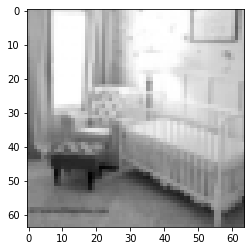

In [ ]:
image, label = next(iter(trainloader))

idx = 8

plt.imshow(image[idx,0,:,:],'gray')
print(label.shape)
print(label[idx])

#Training

In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.6931 | Test_cost  = 0.6892 | Train_score = 0.4948 | Test_score = 0.5000 |




Epoch     2
Train_cost  = 0.6921 | Test_cost  = 0.6823 | Train_score = 0.5000 | Test_score = 0.7000 |




Epoch     3
Train_cost  = 0.6885 | Test_cost  = 0.6714 | Train_score = 0.5260 | Test_score = 0.8000 |




Epoch     4
Train_cost  = 0.6803 | Test_cost  = 0.6520 | Train_score = 0.6302 | Test_score = 0.9000 |




Epoch     5
Train_cost  = 0.6684 | Test_cost  = 0.6198 | Train_score = 0.6771 | Test_score = 0.9000 |
==> EarlyStop patience =  1 | Best test_score: 0.9000




Epoch     6
Train_cost  = 0.6471 | Test_cost  = 0.5638 | Train_score = 0.7292 | Test_score = 0.9000 |
==> EarlyStop patience =  2 | Best test_score: 0.9000




Epoch     7
Train_cost  = 0.6131 | Test_cost  = 0.4824 | Train_score = 0.7240 | Test_score = 0.8000 |
==> EarlyStop patience =  3 | Best test_score: 0.9000




Epoch     8
Train_cost  = 0.5755 | Test_cost  = 0.4245 | Train_score = 0.7083 | Test_score = 0.9000 |
==> EarlyStop patience =  4 | Best test_score: 0.9000




Epoch     9
Train_cost  = 0.5598 | Test_cost  = 0.3734 | Train_score = 0.7031 | Test_score = 0.9000 |
==> EarlyStop patience =  5 | Best test_score: 0.9000
==> Execute Early Stopping at epoch: 9 | Best test_score: 0.9000
==> Best model is saved at model


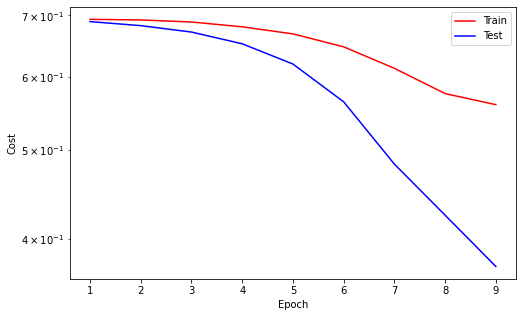

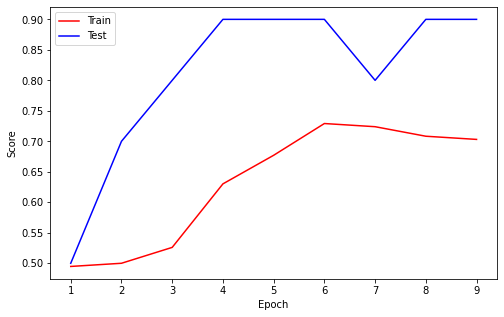

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
  
    #logging
    callback.log(train_cost, test_cost, train_score, test_score)

    #checkpoint
    callback.save_checkpoint()

    #Runtime Ploting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    #Early Stopping
    if callback.early_stopping(model, monitor= "test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

#Predict

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device),target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1])

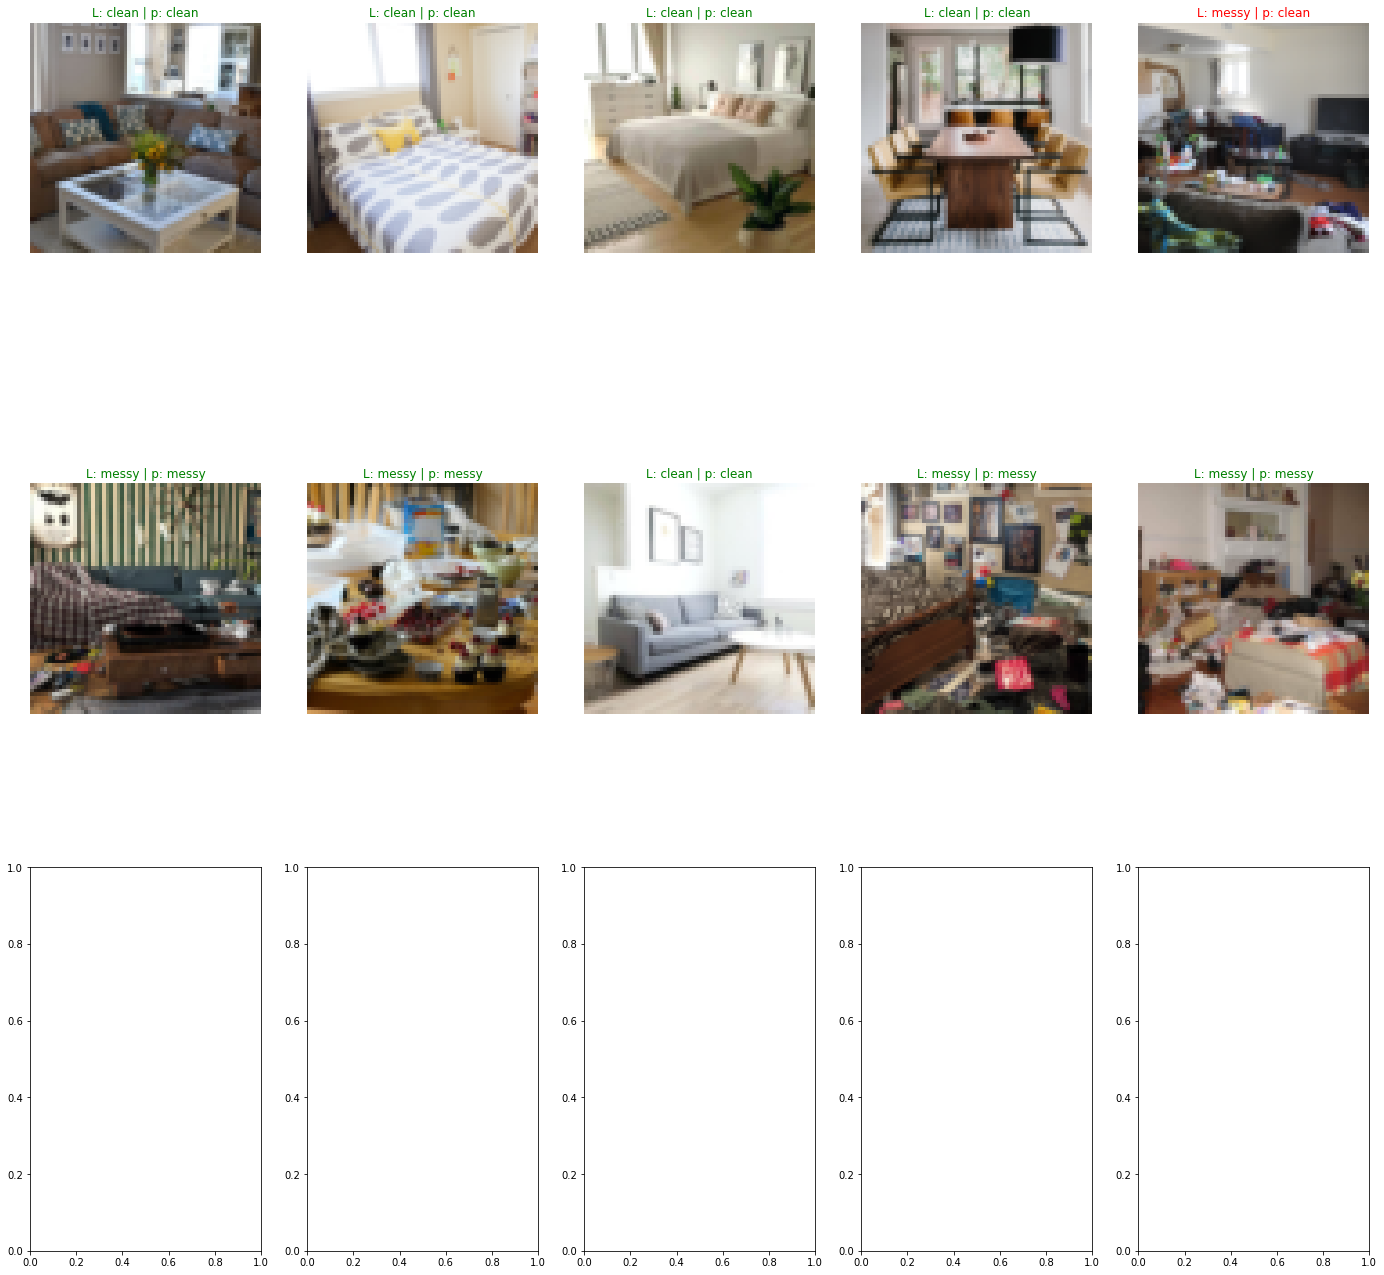

In [ ]:
fig, axes = plt.subplots(3,5,figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color":'r'} if label != pred else {"color":'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | p: {pred}",fontdict=font);
    ax.axis('off');